In [101]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Imports de la libreria propia
from vecopsciml.kernels.derivative import DerivativeKernels
from vecopsciml.utils import TensOps

# Imports de las funciones creadas para este programa
from models.non_constant_diffusivity import NonConstantDiffusivityNeuralNetwork
from utils.folders import create_folder
from utils.load_data import load_data
from trainers.train import train_loop

In [102]:
# Creamos los paths para las distintas carpetas
ROOT_PATH = r'C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning'
DATA_PATH = os.path.join(ROOT_PATH, r'data\non_linear\non_linear.pkl')
RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results\non_linear')
MODEL_RESULTS_PATH = os.path.join(ROOT_PATH, r'results\non_linear\model_paper')

# Creamos las carpetas que sean necesarias (si ya están creadas se avisará de ello)
create_folder(RESULTS_FOLDER_PATH)
create_folder(MODEL_RESULTS_PATH)

Folder already exists at: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\results\non_linear
Folder already exists at: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\results\non_linear\model_paper


In [103]:
# Load dataset
dataset = load_data(DATA_PATH)

Data successfully loaded from: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data\non_linear\non_linear.pkl


In [104]:
# Convolutional filters to derivate
dx = dataset['x_step_size']
dy = dataset['y_step_size']
D = DerivativeKernels(dx, dy, 0).grad_kernels_two_dimensions()

In [105]:
u = torch.Tensor(dataset['y_train'])

In [142]:
f_coef = torch.fft.fft2(u)
F_ordered = f_coef.flatten(start_dim=1)
N = F_ordered.shape[1]

Et = torch.sum(torch.sum(torch.square(torch.abs(u)), dim=1), dim=1)
Ef = torch.sum(torch.sum(torch.square(torch.abs(f_coef)), dim=1), dim=1)/N

In [217]:
energy = []

for index in range(Et.shape[0]):
    energy.append(torch.sum(torch.sum(torch.square(torch.abs(F_ordered[index, :10]))))/N/Et[index])

minimo = np.min(energy)
maximo = np.max(energy)
primer_cuartil = np.percentile(energy, 25)
mediana = np.percentile(energy, 50)
tercer_cuartil = np.percentile(energy, 75)

# Imprimir los resultados
print(f"Mínimo: {minimo:.2e}")
print(f"Primer cuartil (Q1): {primer_cuartil:.2e}")
print(f"Mediana (Q2): {mediana:.2e}")
print(f"Tercer cuartil (Q3): {tercer_cuartil:.2e}")
print(f"Máximo: {maximo:.2e}\n")

minimo = np.min(energy)
indice_minimo = np.argmin(energy)

print(f"El valor mínimo es: {minimo}")
print(f"El índice del valor mínimo es: {indice_minimo}")

Mínimo: 8.65e-01
Primer cuartil (Q1): 9.86e-01
Mediana (Q2): 9.93e-01
Tercer cuartil (Q3): 9.98e-01
Máximo: 1.00e+00

El valor mínimo es: 0.8648183345794678
El índice del valor mínimo es: 5504


In [389]:
mask = np.zeros_like(F_ordered)
mask[:, 0:3] = 1

F_full = f_coef*mask.reshape(f_coef.shape)
u_reconstructed = torch.fft.ifft2(F_full).real

In [391]:
torch.sum(torch.abs(u - u_reconstructed))/torch.sum(torch.abs(u))

tensor(0.0897)

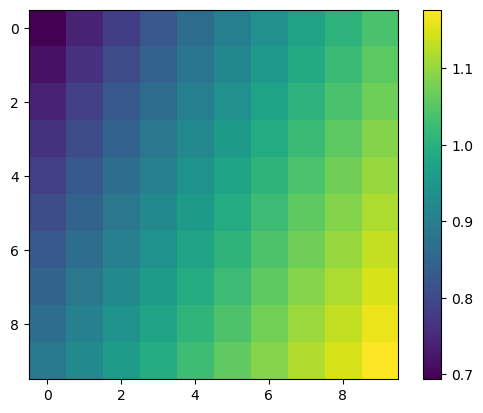

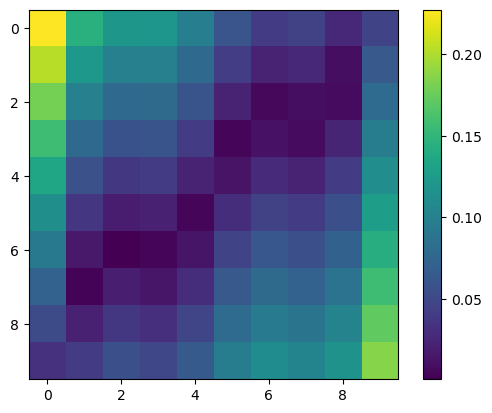

In [392]:
index = 0

plt.imshow(u[index])
plt.colorbar()
plt.show()

plt.imshow(np.abs(u_reconstructed[index] - u[index]))
plt.colorbar()
plt.show()